# Using JAX

Here, we will use JAX to do both the simple method (with the heaviside function) and to explore taking a derivative of this the $S/\sqrt{B}$.

In [1]:
import jax
import jax.numpy as jnp
import numpy
import matplotlib.pyplot as plt
from samples import data_sig, data_back

_ = plt.ion()

In [2]:
# Convert the data to jax arrays
data_sig_j = jnp.asarray(data_sig)
data_back_j = jnp.asarray(data_back)

## Using the Heaviside function

The problem is the derivative is a delta function, and that probably does not work well for what we need to do here - not wide enough.

In [3]:
def wts_by_cut(data, cut:float):
    'Calculate weights for a jax array by a cut using the heaviside function, simulating ">"'

    return jnp.heaviside(jnp.add(data, -cut), 0)

def sig_sqrt_b(cut, apply_wt = wts_by_cut):
    'Calculate the S/sqrt(B) for two 1D numpy arrays with the cut at cut.'

    # Weight the data and then do the sum
    wts_sig = apply_wt(data_sig_j, cut)
    wts_back = apply_wt(data_back_j, cut)

    S = jnp.sum(wts_sig)
    B = jnp.sum(wts_back)

    return S/jnp.sqrt(B)

In [4]:
cut_values = numpy.linspace(-10.0, 10.0, 100)
s_sqrt_b = numpy.array([sig_sqrt_b(c) for c in cut_values])

In [5]:
max_index = numpy.argmax(s_sqrt_b)
print(rf"Max value of $S\sqrt{{B}}$ occurs at {cut_values[max_index]:0.4} and is {s_sqrt_b[max_index]:0.4}.")

Max value of $S\sqrt{B}$ occurs at 3.737 and is 22.44.


### Gradient

Try taking the gradient of this and seeing how it looks - looking for something that bottoms out around 3.737.

In [6]:
d_sig_sqrt_b = jax.grad(sig_sqrt_b)

In [7]:
numpy.array([float(d_sig_sqrt_b(c)) for c in cut_values])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Nope - that isn't going to work!

## Error Function

Lets try the error function. First, we need to design one that has the right turn-on characteristics.

In [8]:
def erf(data, cut: float):
    'Take a jax array and calculate an error function on it'
    return (jax.lax.erf(data-cut)+1)/2.0

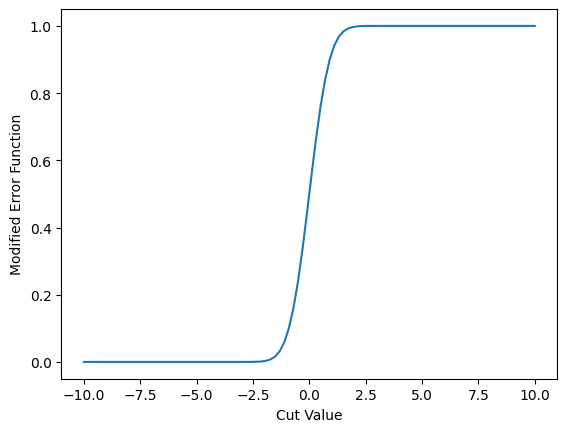

In [9]:
data = erf(cut_values, 0.0)
plt.plot(cut_values, data)
plt.xlabel('Cut Value')
plt.ylabel('Modified Error Function')
plt.show()

In [10]:
def erf_sig_sqrt_b(cut: float):
    return sig_sqrt_b(cut, erf)

In [11]:
cut_values = numpy.linspace(-10.0, 10.0, 100)
erf_s_sqrt_b = numpy.array([erf_sig_sqrt_b(c) for c in cut_values])

In [12]:
max_index = numpy.argmax(erf_s_sqrt_b)
print(rf"Max value of $S\sqrt{{B}}$ occurs at {cut_values[max_index]:0.4} and is {erf_s_sqrt_b[max_index]:0.4}.")
erf_max_value = cut_values[max_index]

Max value of $S\sqrt{B}$ occurs at 3.535 and is 20.88.


Not exactly the same - but good enough for now. We can tune up that error function if we need to.

### Gradient

Lets see if this behaves a little better when we have a gradient.

In [13]:
d_erf_sig_sqrt_b = jax.grad(erf_sig_sqrt_b)

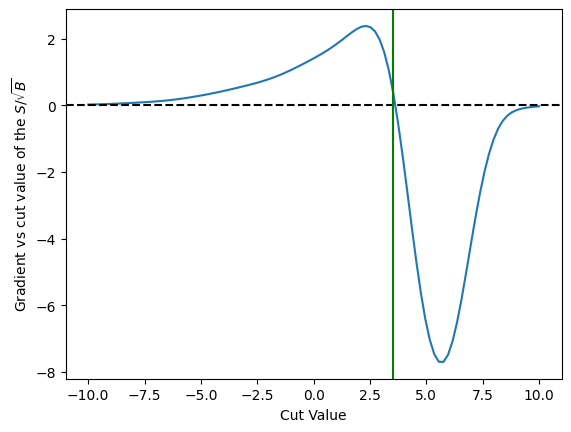

In [16]:
plt.plot(cut_values, numpy.array([d_erf_sig_sqrt_b(c) for c in cut_values]))
plt.xlabel('Cut Value')
plt.ylabel(r'Gradient vs cut value of the $S/\sqrt{B}$')
plt.axhline(0.0, color='black', linestyle='dashed')
plt.axvline(erf_max_value, color='green')
plt.show()

That works! And we can see some gotchas here:

* At the lower and upper limits of cut value we start to run out of data, and the $S\sqrt{B}$ is either zero or undefined - which is a zero for the gradient. In short, one needs to limit where one searches or one will find a false possible value.
* The zero point is about at the right place (the vertical (green) line matches the max point found above). Note it is slightly off, but that has more to do with the fact our `cut_value` may not contain the exact zero.
* And lastly - how the heck are we going to be able to find that zero - this is a wild function - perhaps square it?

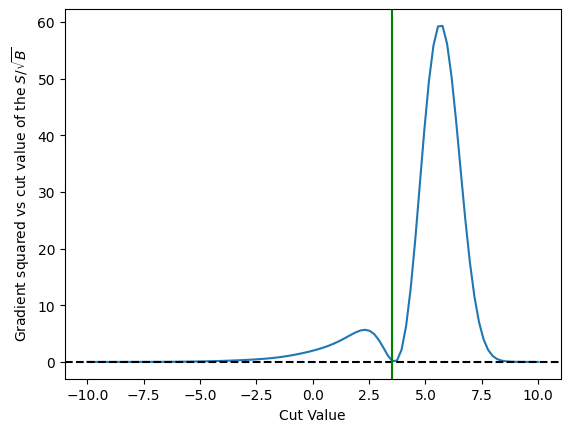

In [18]:
plt.plot(cut_values, numpy.array([d_erf_sig_sqrt_b(c)**2 for c in cut_values]))
plt.xlabel('Cut Value')
plt.ylabel(r'Gradient squared vs cut value of the $S/\sqrt{B}$')
plt.axhline(0.0, color='black', linestyle='dashed')
plt.axvline(erf_max_value, color='green')
plt.show()